In [36]:
pip install -U scikit-learn wordcloud nltk flask


  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached MarkupSafe-2.1.5-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
   ---------------------------------------- 0.0/101.7 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/101.7 kB ? eta -:--:--
   ---------------------------------------- 101.7/101.7 kB 1.9 MB/s eta 0:00:00
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
   ---------------------------------------- 0.0/227.3 kB ? eta -:--:--
   ---------------------------------------- 227.3/227.3 kB 7.0 MB/s eta 0:00:00
Using cached MarkupSafe-2.1.5-cp312-cp312-win_amd64.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


# 1 Logs Tokenization and TFI_ID Vectorization 

**Tokenization:** 
nltk.word_tokenize provides a comprehensive way to split text into words. It handles a wide variety of edge cases and punctuation marks. For instance, it correctly splits contractions (e.g., "don't" into "do" and "n't") and handles punctuation correctly.


**Splitting data:**
The train_test_split function is used to split the processed log entries into training (80%) and test (20%) sets. The objetive is to validate if the vectorizer works well in both datasets.

**TF-IDF Vectorization:**
The TfidfVectorizer is fitted on the training data and then used to transform the test data. This ensures that the same TF-IDF mapping is applied to both datasets.

**The why of 4-grams**

Capturing context: 4-grams capture more context compared to unigrams (single words), bigrams (two-word sequences), and trigrams (three-word sequences). In log files, important patterns and anomalies might span multiple words. Using 4-grams helps in capturing these patterns more effectively.

Identifying specific phrases: in log files, specific actions or error messages might consist of four-word sequences. For instance, phrases like "error occurred while processing" or "connection closed due to timeout" are more likely to be captured and identified as significant when using 4-grams.

Improving anomaly Detection: anomalies in log files often involve specific sequences of operations or messages. By using 4-grams, the vectorizer can better identify unusual sequences that deviate from the norm, thus improving the detection of anomalies.

In [21]:
import re
import os
import glob
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

# Function to read log entries from files
def read_logs():
    log_entries = []
    directory = os.getcwd()  # Get the current working directory
    file_paths = glob.glob(os.path.join(directory, "*.jrn"))
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            log_entries.extend(lines)
    return log_entries

# Function to preprocess log entries
def preprocess_logs(log_entries):
    processed_logs = []
    for entry in log_entries:
        # Simplify whitespace and strip newlines
        entry = entry.strip().replace("\n", "")
        # Remove leading timestamps and operation codes
        entry = re.sub(r"^\s*\d{2}:\d{2}:\d{2}\s+\d+\s+", "", entry)
        # Remove special formatting characters and digits clustered as error codes or IDs
        entry = re.sub(r"\d{2,}", "", entry)  # removes long sequences of digits
        entry = re.sub(r"[<>{}()\[\]]", "", entry)  # removes special characters
        # Tokenize the entry into words
        words = word_tokenize(entry)
        # Filter out non-readable words (e.g., punctuation, numbers)
        readable_words = [word for word in words if word.isalpha() and len(word) > 4]
        # Reconstruct the entry from readable words
        processed_entry = " ".join(readable_words)
        processed_logs.append(processed_entry)
    return processed_logs

# Download necessary NLTK data
nltk.download('punkt')

# Read and preprocess log entries
log_entries = read_logs()
processed_entries = preprocess_logs(log_entries)

# Split the data into training and test sets (80/20 split)
train_entries, test_entries = train_test_split(processed_entries, test_size=0.2, random_state=42)

# TF-IDF Vectorizer using 4-grams
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(4, 4))

# Fit the vectorizer on the training data
tfidf_train_matrix = tfidf_vectorizer.fit_transform(train_entries)

# Transform the test data using the fitted vectorizer
tfidf_test_matrix = tfidf_vectorizer.transform(test_entries)

tfidf_vectorizer.get_feature_names_out()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


array(['accept deposits unable transaction',
       'accept multiples cancel management', 'accept press cancel cancel',
       'account correct number receipt', 'account deposit press checking',
       'account include addition charged',
       'account inquiry press checking',
       'account statement press checking', 'account transfer funds press',
       'account vegas account account', 'account vegas debit account',
       'account withdraw funds press', 'addition charged continue print',
       'addition charged continue select',
       'addition charged financial institution',
       'addition requested addition charged',
       'adjust volume terminal press',
       'adjustment cancel denomination cancel',
       'agencia institucion financiera obtener',
       'agent money retract counter', 'agent paper state unknown',
       'agent reactivate devices cccardfw',
       'agent reactivate devices cccdmfw',
       'agent reactivate devices result', 'agent retain counter initial',

# 2 TF_ID Scores Analysis in training set


The code calculates the mean TF-IDF score for each term in the training set, sorts these terms by their scores, and then identifies the terms that fall within the 80th to 100th percentile range. This threshold is important for detecting anomalies because it highlights high-value features that are likely to be indicative of significant patterns or issues, thus aiding in more accurate and relevant anomaly detection.

In [32]:
# Compute mean TF-IDF score for each term
mean_tfidf_scores = tfidf_train_matrix.mean(axis=0).tolist()[0]
terms = tfidf_vectorizer.get_feature_names_out()

# Sort terms based on their TF-IDF scores in ascending order
sorted_terms_by_tfidf = sorted(zip(terms, mean_tfidf_scores), key=lambda x: x[1])

# Calculate percentile values
total_terms = len(sorted_terms_by_tfidf)
percentile_80 = int(total_terms * 0.80)
percentile_100 = int(total_terms *  1)

# Get terms within the 80th to 100th percentile range
terms_in_percentile_range = sorted_terms_by_tfidf[percentile_80:percentile_100]

# Print the terms within the specified percentile range
print("Terms within the 80th to 100th percentile range of TF-IDF scores:")
for term, score in terms_in_percentile_range:
    if 'close' in term.lower():
        print(f"{term}: {score}")
    if 'error' in term.lower():
         print(f"{term}: {score}")
    

Terms within the 80th to 100th percentile range of TF-IDF scores:
command returning state closed: 7.961886290698363e-05
error ccguiagent successfully started: 8.53888815029307e-05
error ccscanneragent successfully started: 8.863149725620653e-05
error ccprinteragent successfully started: 8.971236917396514e-05
application error management ready: 9.079324109172376e-05
error detailed failure information: 9.079324109172376e-05
error ccjournalagent successfully started: 9.187411300948237e-05
error ccselagent successfully started: 9.187411300948237e-05
error cclogicalagent successfully started: 9.403585684499959e-05
error ccttsagent successfully started: 9.403585684499959e-05
error cccashoutagent successfully started: 9.619760068051682e-05
error cccardagent successfully started: 9.727847259827543e-05
error cceppagent successfully started: 9.835934451603404e-05
application starting error management: 0.00010052108835155126
errornr class insert ddcstatus: 0.00010467921225719545
application state

## 2.1 Histograms of TF_ID Scores for each term in training set

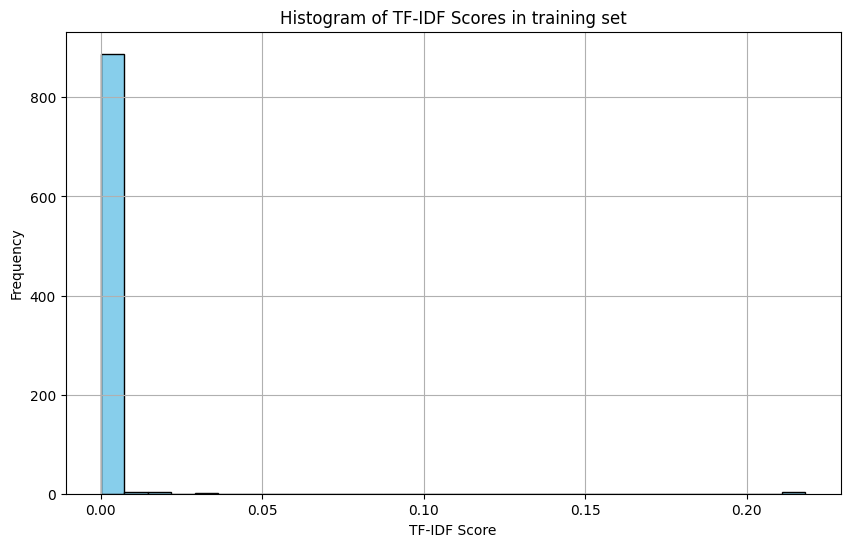

In [23]:
import matplotlib.pyplot as plt

# Assuming you have already computed mean_tfidf_scores and terms
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(mean_tfidf_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of TF-IDF Scores in training set')
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# 2.2 Word cloud with the percentil range 80-100 for anomalies detection in training set 

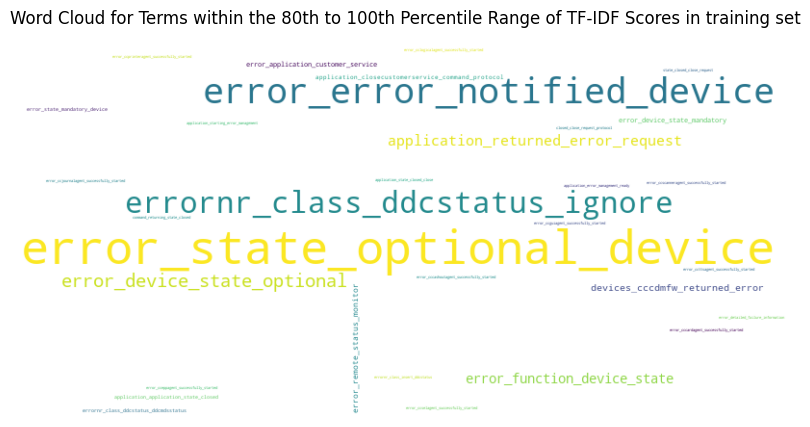

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate terms (4-grams) using underscores
cleaned_terms = [(term[0].replace(' ', '_'), term[1]) for term in terms_in_percentile_range if 'error' in term[0] or 'close' in term[0]]


# Create a dictionary of terms and their TF-IDF scores
terms_scores_dict = {term: score for term, score in cleaned_terms}

# Generate word cloud using TF-IDF scores as frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white',max_font_size=150).generate_from_frequencies(terms_scores_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Terms within the 80th to 100th Percentile Range of TF-IDF Scores in training set')
plt.show()


# 3 TF_ID Scores Analysis in test set

In [26]:
# Compute mean TF-IDF score for each term
mean_tfidf_scores = tfidf_test_matrix.mean(axis=0).tolist()[0]
terms = tfidf_vectorizer.get_feature_names_out()

# Sort terms based on their TF-IDF scores in ascending order
sorted_terms_by_tfidf = sorted(zip(terms, mean_tfidf_scores), key=lambda x: x[1])

# Calculate percentile values
total_terms = len(sorted_terms_by_tfidf)
percentile_80 = int(total_terms * 0.80)
percentile_100 = int(total_terms *  1)

# Get terms within the 80th to 100th percentile range
terms_in_percentile_range = sorted_terms_by_tfidf[percentile_80:percentile_100]

# Print the terms within the specified percentile range
print("Terms within the 80th to 100th percentile range of TF-IDF scores:")
for term, score in terms_in_percentile_range:
    if 'close' in term.lower():
        print(f"{term}: {score}")
    if 'error' in term.lower():
         print(f"{term}: {score}")
    

Terms within the 80th to 100th percentile range of TF-IDF scores:
errornr class insert ddcstatus: 7.468919894030478e-05
error error management successfully: 7.642910365405086e-05
error management successfully started: 7.642910365405086e-05
error ccttsagent successfully started: 7.782269396225602e-05
error ccguiagent successfully started: 8.646965995806224e-05
error ccselagent successfully started: 8.646965995806224e-05
command returning state closed: 8.957578765843086e-05
application starting error management: 9.511662595386847e-05
error ccprinteragent successfully started: 9.511662595386847e-05
error ccscanneragent successfully started: 9.944010895177158e-05
error cceppagent successfully started: 0.00010376359194967469
error cccardagent successfully started: 0.0001080870749475778
error cccashoutagent successfully started: 0.00011241055794548092
application state closed close: 0.00011610157658188871
closed close request protocol: 0.00011610157658188871
state closed close request: 0.000

## 3.1 Histograms of TF_ID Scores for each term in test set

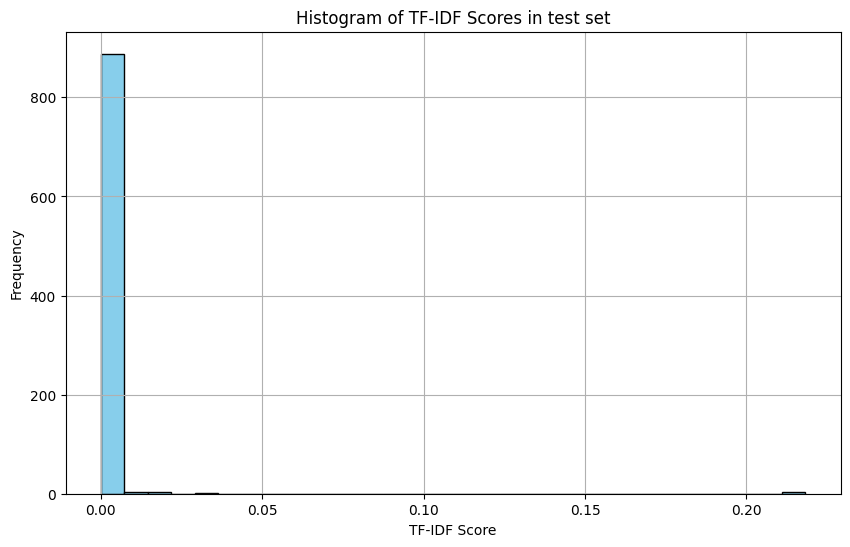

In [27]:
import matplotlib.pyplot as plt

# Assuming you have already computed mean_tfidf_scores and terms
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(mean_tfidf_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of TF-IDF Scores in test set')
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3.2 Word cloud with the percentil range 80-100 for anomalies detection in test set 

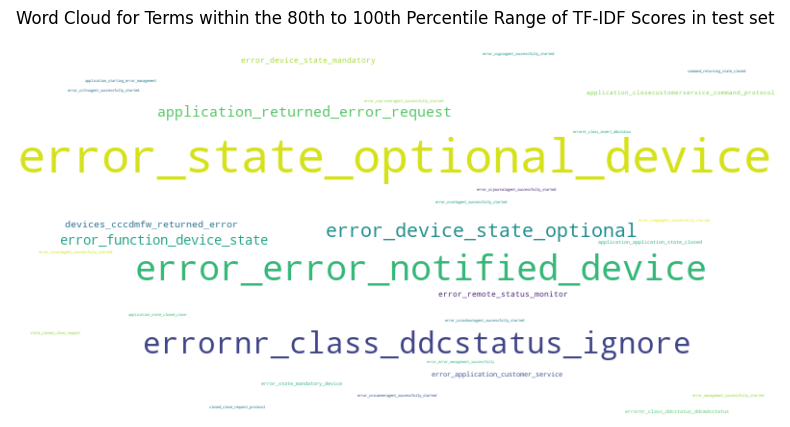

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate terms (4-grams) using underscores
cleaned_terms = [(term[0].replace(' ', '_'), term[1]) for term in terms_in_percentile_range if 'error' in term[0] or 'close' in term[0]]


# Create a dictionary of terms and their TF-IDF scores
terms_scores_dict = {term: score for term, score in cleaned_terms}

# Generate word cloud using TF-IDF scores as frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white',max_font_size=150).generate_from_frequencies(terms_scores_dict)

# Plot the word cloud
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Terms within the 80th to 100th Percentile Range of TF-IDF Scores in test set')
plt.show()


# 4 Make TFID_Vectorizer persistent to be used in a REST API

## 4.1 Save the model

In [34]:
import joblib

# Save the trained TfidfVectorizer to a file
joblib_file = "tfidf_vectorizer.pkl"
joblib.dump(tfidf_vectorizer, joblib_file)

['tfidf_vectorizer.pkl']

# 4.2 Integrating model to a REST API in Flask

In [39]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# Load the trained TfidfVectorizer
joblib_file = "tfidf_vectorizer.pkl"
tfidf_vectorizer = joblib.load(joblib_file)

@app.route('/predict', methods=['POST'])
def predict():
    # Get the log entry from the request
    data = request.json
    log_entry = data.get('log_entry')
    
    if log_entry:
        # Preprocess the log entry 
        processed_entry = preprocess_logs([log_entry])
        
        # Transform the preprocessed log entry using the model
        tfidf_matrix = tfidf_vectorizer.transform(processed_entry)
        
       #Logic to return data
        mean_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]
        terms = tfidf_vectorizer.get_feature_names_out()

        # Sort terms based on their TF-IDF scores in ascending order
        sorted_terms_by_tfidf = sorted(zip(terms, mean_tfidf_scores), key=lambda x: x[1])

        # Calculate percentile values
        total_terms = len(sorted_terms_by_tfidf)
        percentile_80 = int(total_terms * 0.80)
        percentile_100 = int(total_terms *  1)

        # Get terms within the 80th to 100th percentile range
        terms_in_percentile_range = sorted_terms_by_tfidf[percentile_80:percentile_100]
        cleaned_terms = [(term[0].replace(' ', '_'), term[1]) for term in terms_in_percentile_range if 'error' in term[0] or 'close' in term[0]]

        response = {
            'percentil_80_100': cleaned_terms
        }
        return jsonify(response)
    else:
        return jsonify({'error': 'No log entry provided'}), 400

if __name__ == '__main__':
    app.run(debug=False,port=5001)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
